# Solutions to homework week 4 - Evaluation

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [4]:
# check working directory to debug path to loading
#import os
#os.getcwd()

# load the data
df = pd.read_csv('../data/lead_scoring.csv')

In [5]:
# df.lead_source.value_counts().head()
categorical_columns = ['lead_source', 'industry', 'employment_status', 'location']
numeric_columns = ['number_of_courses_viewed', 'annual_income','interaction_count','lead_score']

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [6]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [7]:
missing_values_dict = {}
for c in categorical_columns:
    missing_values_dict[c] = 'NA'

for n in numeric_columns:    
    missing_values_dict[n] = 0
# df.fillna(value=values)
df = df.fillna(value=missing_values_dict)

In [8]:
#Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. 
# Use `train_test_split` function for that with `random_state=1`
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
# adjust proportion test size to be 20% of the remaining 80% after first split
df_train, df_val = train_test_split(df_full_train, test_size=0.2/(0.8), random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_full_train = df_full_train.reset_index(drop=True)

y_full_train = df_full_train.converted.values
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_full_train['converted']
del df_train['converted']
del df_val['converted']
del df_test['converted']


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [9]:
def train(df_train, y_train, features, C=1.0):    
    # extract numpy array
    X_train = df_train[features].values.reshape(-1, 1)

    model = LogisticRegression(solver='lbfgs', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return model

def predict(df, model, features):
    # extract numpy array
    X = df[features].values.reshape(-1, 1)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred


In [10]:
for numeric_feature in numeric_columns:
    model = train(df_train, y_train, features=numeric_feature)
    y_pred = predict(df_val, model, features=numeric_feature)
    score_auc = roc_auc_score(y_val, y_pred)
    print(numeric_feature, " := %.3f"  % score_auc)

number_of_courses_viewed  := 0.742
annual_income  := 0.554
interaction_count  := 0.697
lead_score  := 0.623


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)


In [11]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numeric_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear',C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical_columns + numeric_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [12]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)
score_auc = roc_auc_score(y_val, y_pred)
print("%.3f" % score_auc)

0.817


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

In [23]:
def precision_recall_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    #df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    #df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    return(df_scores)

In [26]:
df_pre_rec = precision_recall_dataframe(y_val, y_pred)

# review every 10th record
df_pre_rec[::10]

,threshold,tp,fp,fn,tn,precision,recall
0,0.0,142,91,0,0,0.609442,1.000000
10,0.1,142,91,0,0,0.609442,1.000000
20,0.2,142,91,0,0,0.609442,1.000000
30,0.3,142,87,0,4,0.620087,1.000000
40,0.4,138,68,4,23,0.669903,0.971831
50,0.5,132,48,10,43,0.733333,0.929577
60,0.6,115,25,27,66,0.821429,0.809859
70,0.7,84,10,58,81,0.893617,0.591549
80,0.8,54,1,88,90,0.981818,0.380282
90,0.9,16,0,126,91,1.000000,0.112676


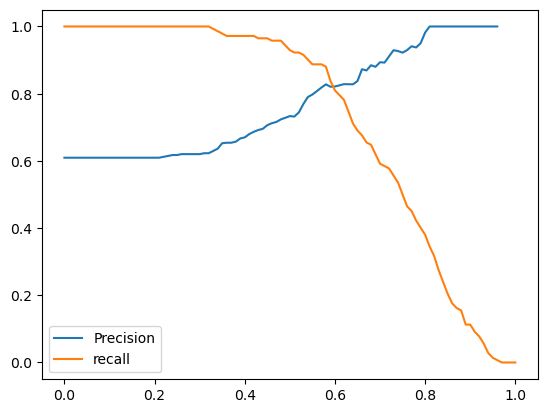

In [29]:
plt.plot(df_pre_rec.threshold, df_pre_rec['precision'], label='Precision')
plt.plot(df_pre_rec.threshold, df_pre_rec['recall'], label='recall')
plt.legend()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [13]:
def f1_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    #df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    #df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['f1'] = 2 * (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)
    
    return df_scores

In [14]:
df_f1 = f1_dataframe(y_val, y_pred)

# review every 10th record
df_f1[::10]


,threshold,tp,fp,fn,tn,precision,recall,f1
0,0.0,171,122,0,0,0.583618,1.000000,0.737069
10,0.1,171,122,0,0,0.583618,1.000000,0.737069
20,0.2,171,122,0,0,0.583618,1.000000,0.737069
30,0.3,171,119,0,3,0.589655,1.000000,0.741866
40,0.4,171,105,0,17,0.619565,1.000000,0.765101
50,0.5,164,81,7,41,0.669388,0.959064,0.788462
60,0.6,150,53,21,69,0.738916,0.877193,0.802139
70,0.7,106,25,65,97,0.809160,0.619883,0.701987
80,0.8,64,6,107,116,0.914286,0.374269,0.531120
90,0.9,24,1,147,121,0.960000,0.140351,0.244898


In [15]:
f1_max = df_f1['f1'].max()
f1_threshold = df_f1[f1_max == df_f1['f1']]['threshold']
print("Threshold = ","%.2f" % f1_threshold.values[0],"; F1 = ", "%.3f" % f1_max)

Threshold =  0.57 ; F1 =  0.812


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

In [16]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

score = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = y_full_train[train_idx] 
    y_val = y_full_train[val_idx] 

    dv, model = train(df_train, y_train, C=1)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    score.append(auc)

In [17]:
print('%.3f, +- %.3f' % (np.mean(score), np.std(score)))

0.822, +- 0.036


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

In [18]:
n_splits = 5

score_stats = {}

for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = y_full_train[train_idx] 
        y_val = y_full_train[val_idx] 

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    #print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))
    score_stats[C] = {"mean": np.mean(scores), "std": np.std(scores)}

In [19]:
pd.DataFrame(score_stats)

,0.000001,0.001000,1.000000
mean,0.560208,0.866878,0.822109
std,0.023798,0.028746,0.035807
